# Sleep-scoring as an image classification task

In this notebook, we will use transfer learning with two types of images to classify sleep states in *PyTorch*:
1. Images of the raw trace of EEG and EMG signals
2. Spectograms of the EEG and EMG signals

Please note that the code concerning the training of the networks are for illustration and are not runnable in this notebook. The actual training was performed on my local machine was performed with the scripts:
* c1_eeg1_trial1.py
* c1_eeg1emg_trial1.py

All the data and trained models can be downloaded [here](https://upenn.box.com/s/ibbmqfcqsnqtbfwde5r869cl87k3zqeb).

In [1]:
# Import necessary packages
import os
import rempropensity as rp
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import scipy.io as so
import seaborn as sns

# List containing all recordings
ppath = '/home/spark/Desktop/24hours'
recordings = os.listdir(ppath)

## Preparing the input data

### Example of raw trace

While there is no 'correct' choice for size of window/bin with which we split and annotate the sleep recording, we will use 2.5 s as this is the convention used at the [Weber Lab](https://www.med.upenn.edu/weberlab/). Some other common choices in the literature are 4 s and 10 s.

The raw trace images:
* Each image will be 256*256 pixels
* The color of the trace will be black
* We will use a single 2.5 s bin (2500 EEG data points)
* We will turn off the axis so that only the EEG waveform is visible
* We will have 3 images for each bin as we have 3 channels: EEG1 (parietal EEG), EEG2 (prefrontal EEG), EMG

Below, we will show an example of what the raw image data look like for a single 2.5 s bin:

(-124.95, 2623.95, -929.8770000000001, 677.157)

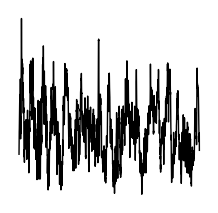

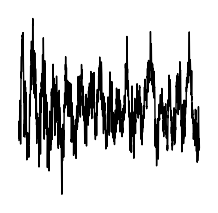

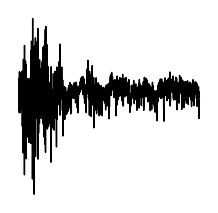

In [3]:
%matplotlib inline

# Single recording
rec = recordings[0]

# Load eeg and emg
eeg1 = np.squeeze(so.loadmat(os.path.join(ppath, rec, 'EEG.mat'))['EEG'])
eeg2 = np.squeeze(so.loadmat(os.path.join(ppath, rec, 'EEG2.mat'))['EEG2'])
emg = np.squeeze(so.loadmat(os.path.join(ppath, rec, 'EMG.mat'))['EMG'])

#Plot 1st 2.5 s bin
xes = range(2500)

# eeg1
plt.figure(figsize=(2.56,2.56),dpi=100)
plt.plot(xes, eeg1[0:2500], color='k', lw=1)
plt.axis('off')

# eeg2
plt.figure(figsize=(2.56,2.56),dpi=100)
plt.plot(xes, eeg2[0:2500], color='k', lw=1)
plt.axis('off')

# emg
plt.figure(figsize=(2.56,2.56),dpi=100)
plt.plot(xes, emg[0:2500], color='k', lw=1)
plt.axis('off')

### Example of Spectogram

In order to preserve more information, we will use 3 consecutive bins when making the spectogram. Below is an example of the spectogram of EEG1:

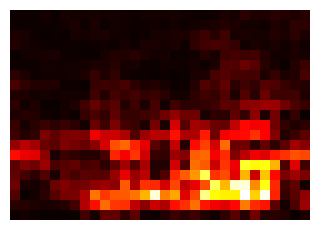

In [4]:
%matplotlib inline

ind1 = 1
start = ind1 - 1
end = ind1 + 2
eeg_start = start*2500
eeg_end = end*2500
subarrays = []
for substart in np.arange(eeg_start, eeg_end, 250):
    seqstart = substart - 500
    seqend = substart + 1000
    sup = list(range(seqstart, seqend+1))
    Pow,F = rp.power_spectrum(eeg1[sup],1000,1/1000)
    ifreq = np.where((F>=0)&(F<=20))
    subPow = Pow[ifreq]
    subarrays.append(subPow)
totPow = np.stack(subarrays, axis=1)

fig3 = plt.figure(figsize=(3.0,2.1),dpi=100)
plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0,wspace=0)
plt.imshow(totPow,cmap='hot',interpolation='nearest',origin='lower')
plt.gca().set_axis_off()
plt.margins(0,0)
plt.axis('off')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())


### Making all the images

We currently have all the sleep recordings in one directory titled 'AC_data' as below:

<code>AC_data/
/HA37_081618n1
/HA44_081618n1
...
/c49_042418n1
</code>

We want to loop through all the recordings and save images of the EEG,EMG raw trace. We will store the images in the following structure:

<code>picData/
/HA37_081618n1/eeg1/0.png
/HA37_081618n1/eeg1/1.png
...
/HA37_081618n1/eeg2/0.png
/HA37_081618n1/eeg2/1.png
...
/HA37_081618n1/emg/0.png
/HA37_081618n1/emg/1.png
...
...
/c49_042418n1/eeg1/0.png
/c49_042418n1/eeg1/1.png
...
/c49_042418n1/eeg2/0.png
/c49_042418n1/eeg2/1.png
...
/c49_042418n1/emg/0.png
/c49_042418n1/emg/1.png
</code>

The following code illustrates how we would loop through a recording and make images for each 2.5 s bin:
```python
# Load recording and annotation
rec = recordings[0]
M,S = rp.load_stateidx(ppath, rec)

# path to save image
savepath = '/path/to/image'


xes = range(2500)

ind1 = 0
while ind1 < len(M)-1:
    eeg_start = 2500*ind1
    eeg_end = 2500*(ind1+1)
    subeeg = EEG[eeg_start:eeg_end]
    fig1 = plt.figure(figsize=(2.56,2.56),dpi=100)
    plt.plot(xes, subeeg, lw=1, color='k')
    plt.axis('off')
    fig1.savefig(os.path.join(savepath, str(ind1)+'.png'))
    plt.close(fig1)
    ind1+=1
```

On my local machine, I used the script *make_pics.py* to loop through every recording and make images of the raw traces of EEG1, EEG2, and EMG. The script *make_spec.py* was similarly used to make spectograms. Both scripts use the package 'multiprocessing' to speed up the process.

### Train / validation split

We now split the images we made into training and validation data. We will make test data images from different sleep recordings.

From the images we already made, we will take 80% as training data and 20% as validation data. However, we will not be sampling 20% completely randomly because of the distribution of the three states.

([<matplotlib.patches.Wedge at 0x7fd3bb795fd0>,
 [Text(1.0629115185372582, 0.2832297720240933, 'REM'),
  Text(-0.9866556614337699, 0.4863235607706974, 'NREM'),
  Text(0.8281693638180201, -0.7239720331844706, 'Wake')],
 [Text(0.5797699192021408, 0.1544889665585963, '8.3%'),
  Text(-0.5381758153275108, 0.26526739678401673, '68.8%'),
  Text(0.4517287439007382, -0.39489383628243846, '22.9%')])

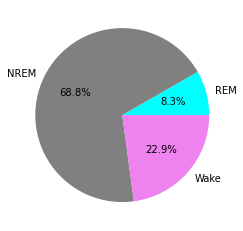

In [5]:
%matplotlib inline

# Process and compile all sleep recordings in folder into one dataframe

remDF = rp.standard_recToDF(ppath, recordings, 8, False)

totDur = [sum(remDF.rem), sum(remDF.sws), sum(remDF.wake)]
lbls = ['REM','NREM','Wake']
cols = ['cyan','grey','violet']

plt.pie(totDur, labels=lbls, autopct='%1.1f%%', colors=cols)

As we can see, a majority of the time is spent in NREM sleep and only 8.3% of the bins are REM. Instead of randomly selecting 20% of all bins to be part of the validation dataset, we will ensure that 20% of each state get evenly selected.

When splitting the dataset, we will also consider how we want to load our training and validation data when we train our network later on. We will be using PyTorch's *ImageFolder* class, which inherits from the *DatasetFolder* class. Our images will be arranged in the following way:

<code>root/rem/xxx.png
root/rem/xxy.png
root/rem/xxz.png
</code>

<code>root/nrem/xxx.png
root/nrem/xxy.png
root/nrem/xxz.png
</code>

<code>root/wake/xxx.png
root/wake/xxy.png
root/wake/xxz.png
</code>


The code below illustrates the process of splitting the training and validation data:

```python
# Path to folders of training and validation data for all 3 states
train_rem_path = 'root/eeg1/train/rem'
train_nrem_path = 'root/eeg1/train/nrem'
train_wake_path = 'root/eeg1/train/wake'

val_rem_path = 'root/eeg1/val/rem'
val_nrem_path = 'root/eeg1/val/nrem'
val_wake_path = 'root/eeg1/val/wake'

picpath = '.../picData' # path containing all images
ppath = '/home/spark/Desktop/24hours' #path containing recordings
recordings = os.listdir(ppath)

for rec in recordings:
    M,S = rp.load_stateidx(ppath, rec) #load annotation
    eeg1path = os.path.join(picpath,rec,'eeg1') #path containing eeg1 images for given recording
    allpics = os.listdir(eeg1path) # Get list of all images
    
    # Keep track of the number of bins of each state
    remcnt = 0
    nremcnt = 0
    wakecnt = 0
    
	for pic in allpics:
		ind = int(pic.split('.')[0]) #get index of current image
		state = M[ind] # get state of current image
		if state==0: # Artefact
			pass
		elif state==1: # REM
			remcnt+=1
			if remcnt%5==1: # Validation
				shutil.copyfile(os.path.join(eeg1path, pic), os.path.join(val_rem_path, rec+'_'+pic))
			else: # Train
				shutil.copyfile(os.path.join(eeg1path, pic), os.path.join(train_rem_path, rec+'_'+pic))
		elif state==2: # Wake
			wakecnt+=1
			if wakecnt%5==1:
				shutil.copyfile(os.path.join(eeg1path, pic), os.path.join(val_wake_path, rec+'_'+pic))
			else:
				shutil.copyfile(os.path.join(eeg1path, pic), os.path.join(train_wake_path, rec+'_'+pic))
		else: # NREM
			nremcnt+=1
			if nremcnt%5==1:
				shutil.copyfile(os.path.join(eeg1path, pic), os.path.join(val_nrem_path, rec+'_'+pic))
			else:
				shutil.copyfile(os.path.join(eeg1path, pic), os.path.join(train_nrem_path, rec+'_'+pic))
```

On my local machine, I used the script *copy_pics.py*, which copies images of not only EEG1 but also of EEG2 and EMG.

## Network architecture and input data configuration

In this notebook, we will be finetuning ResNet18 with pretrained weights and modify only the fully connected layers. We will test out 3 different input data configurations (3 each for the signal trace images and spectograms):
* EEG1 as input
* EEG2 as input
* EEG1 and EMG as input

As the images for EEG1 and EEG2 have the same size, the actual code will be identical. For simplicity, we will refer to the 1st two configurations as **single_input** and the 3rd configuration as **double_input**. Note that the code for using the raw trace images or spectograms will be the same.

```python
from __future__ import print_function, division

import torch
import os
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import pandas as pd
from torch.utils.data import Dataset
import torch.nn.functional as F
```

### single_input

#### Dataset
We are using the *ImageFolder* class. Since we already have images saved in the appropriate class folders, we don't have to create a custom DataSet.

#### Network architecture for single_input
```python
# Load pretrained ResNet18
model_finetune = models.resnet18(pretrained=True)

# Set new size of output layer (REM,NREM,Wake --> 3)
num_ftrs = model_finetune.fc.in_features 
model_finetune.fc = nn.Linear(num_ftrs, 3) 

```
Because we are using a pretrained model provided by *torchvision*, all we had to do was change the number of neurons in the output layer.


### double_input

#### Dataset
```python
class twochannelDataset(Dataset):
	def __init__(self, path_eeg1, path_emg, transform=None):
		self.data_eeg1 = datasets.ImageFolder(root=path_eeg1, transform=transform)
		self.data_emg = datasets.ImageFolder(root=path_emg, transform=transform)

	def __getitem__(self, index):
		x_eeg1, y = self.data_eeg1[index]
		x_emg, _ = self.data_emg[index]
		x = torch.cat((x_eeg1,x_emg),dim=0)
		return x_eeg1, x_emg, y

	def __len__(self):
		return len(self.data_eeg1)

	def whatclass(self):
		return self.data_eeg1.classes
```
We define a custom dataset called 'twochannelDataset'. Upon initialization, it takes as parameters, 2 paths corresponding to the directories containing the images for EEG1 and EMG. `get_item()` returns the eeg1 image, eeg2 image, and the corresponding label(REM,NREM, or Wake). More specifically, because we will pass `transforms.ToTensor()` as a parameter at initialization, the `get_item()` method will return the tensors containing the pixel information about the image.


#### Network architecture for double_input

```python
class twoChannelNet(nn.Module):
	def __init__(self):
		super(twoChannelNet, self).__init__()

		eeg1_modules = list(models.resnet18().children())[:-1]
		self.model1 = nn.Sequential(*eeg1_modules)

		emg_modules = list(models.resnet18().children())[:-1]
		self.model2 = nn.Sequential(*emg_modules)

		self.fc1 = nn.Linear(1024, 100)
		self.fc2 = nn.Linear(100, 10)
		self.fc3 = nn.Linear(10, 3)

	def forward(self, eeg1, emg):
		a = self.model1(eeg1)
		b = self.model2(emg)
		x = torch.cat((a.view(a.size(0),-1), b.view(b.size(0),-1)),dim=1)
		x = F.relu(self.fc1(x))
		x = F.relu(self.fc2(x))
		x = self.fc3(x)
		return x
```
Once again, we use ResNet18. However, now we have 2 inputs (EEG1 and EMG). During the forward step of training, each the EEG1 and EMG images go through separate pretrained ResNet18's. The resulting output vectors are concatenated to form one large vector. This vector then goes through 3 fully connected layers. Again, the output layer has 3 neurons to match the 3 classes.

## Load Data

### single_mode
```python
data_transforms = {
    'train': transforms.Compose([transforms.ToTensor()]),
    'val': transforms.Compose([transforms.ToTensor()])
}

data_dir = 'root/single_mode/picData/eeg1'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128, shuffle=True, num_workers=8) for x in ['train','val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
```

### double_mode
```python
trainpath1 = 'root/double_mode/picData/train/eeg1'
trainpath2 = 'root/double_mode/picData/train/emg'
valpath1 = 'root/double_mode/picData/val/eeg1'
valpath2 = 'root/double_mode/picData/val/emg'

train_set = twochannelDataset(trainpath1, trainpath2, transforms.Compose([transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=8)
valid_set = twochannelDataset(valpath1, valpath2, transforms.Compose([transforms.ToTensor()]))
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=True, num_workers=8)

image_datasets = {
    'train': train_set,
    'val': valid_set
}

dataloaders = {
    'train':train_loader,
    'val':valid_loader
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].whatclass()
```

## Training

Below is a function to train our model for the **single_mode**. The function for **double_mode** only has slight differences.

### single_mode
```python
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    # Keep track of total training time
	since = time.time()
	
    # Store best model and best-rem-model (highest accuracy for REM)
	best_model_wts = copy.deepcopy(model.state_dict())
	best_acc = 0.0

	best_rem_model = copy.deepcopy(model.state_dict())
	best_rem_acc = 0.0
    
    # Lists to keep track of overall loss/accuracy & state loss/accuracy for each epoch
	train_loss = []
	val_loss = []
	train_accuracy = []
	val_accuracy = []
	val_rem_acc = []
	val_nrem_acc = []
	val_wake_acc = []
    
    # Loop through data for given number of epochs
	for epoch in range(num_epochs):
		epoch_start = time.time()
		print('Epoch {}/{}'.format(epoch, num_epochs-1))
		print('-' * 10)
		# Each epoch consists of training and validation phase
		for phase in ['train','val']:
			if phase == 'train':
				model.train() # Model is set to training mode
			else:
				model.eval() # Model is set to evaluate mode
			
            # Keep track of loss and accuracy
			running_loss = 0.0
			running_corrects = 0
			running_remcorrects = 0
			running_nremcorrects = 0
			running_wakecorrects = 0
			running_remtots = 0
			running_nremtots = 0
			running_waketots = 0
			
            # Loop through data
			for inputs,labels in dataloaders[phase]:
				inputs = inputs.to(device)
				labels = labels.to(device)
				
                # zero the parameter gradients
				optimizer.zero_grad()
                
				# forward step
				with torch.set_grad_enabled(phase == 'train'):
					outputs = model(inputs)
					_, preds = torch.max(outputs, 1)
					loss = criterion(outputs, labels)
				# backward step
					if phase == 'train':
						loss.backward()
						optimizer.step()
				# Update loss and other statistics
				running_loss += loss.item() * inputs.size(0)
				running_corrects += torch.sum(preds == labels.data)
				running_remtots += torch.sum(labels.data == 1)
				running_remcorrects += torch.sum((labels.data==1)&(preds==labels.data))
				running_nremtots += torch.sum(labels.data == 0)
				running_nremcorrects += torch.sum((labels.data==0)&(preds==labels.data))
				running_waketots += torch.sum(labels.data == 2)
				running_wakecorrects += torch.sum((labels.data==2)&(preds==labels.data))
			
            # scheduler
			if phase == 'train':
				scheduler.step()
			
            # Calculate loss and accuracy
			epoch_loss = running_loss / dataset_sizes[phase]
			epoch_acc = running_corrects.double() / dataset_sizes[phase]
			epoch_remacc = running_remcorrects.double() / running_remtots
			epoch_nremacc = running_nremcorrects.double() / running_nremtots
			epoch_wakeacc = running_wakecorrects.double() / running_waketots

			if phase=='train':
				train_loss.append(epoch_loss)
				train_accuracy.append(epoch_acc)
			else:
				val_loss.append(epoch_loss)
				val_accuracy.append(epoch_acc)
				val_rem_acc.append(epoch_remacc)
				val_nrem_acc.append(epoch_nremacc)
				val_wake_acc.append(epoch_wakeacc)

            # Print overall accuracy and state accuracy for epoch
			print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
			print('REM accuracy is: ' + str(epoch_remacc))
			print('NREM accuracy is: ' + str(epoch_nremacc))
			print('WAKE accuracy is: ' + str(epoch_wakeacc))
			
            # Time taken for epoch
			if phase == 'val':
				print(time.time() - epoch_start)
            # deep copy the model with the best overall accuracy
			if phase == 'val' and epoch_acc > best_acc:
				best_acc = epoch_acc
				best_model_wts = copy.deepcopy(model.state_dict())
            # deep copy the model with the beset 'rem' accuracy
			if phase == 'val' and epoch_remacc > best_rem_acc:
				best_rem_acc = epoch_remacc
				best_rem_model = copy.deepcopy(model.state_dict())

		print()
	
    # Total training time
	time_elapsed = time.time() - since
	print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
	print('Best val Acc: {:4f}'.format(best_acc))
	
    # Load best model weights
	model.load_state_dict(best_model_wts)
    
	return model, best_rem_model, train_loss, train_accuracy, val_loss, val_accuracy, val_rem_acc, val_nrem_acc, val_wake_acc
```
Some key things that this function does:
* Copies and returns the model with the best overall accuracy and best accuracy for the class 'REM'
* Returns a list of overall validation accuracy and state accuracy for each epoch
* Uses a scheduler instead of a fixed learning rate

### double_mode
Because the double_mode takes two inputs, there is a slight difference in the code when loading the data:

```python
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    ...
    
    # Loop through data for given number of epochs
	for epoch in range(num_epochs):
        ...
			
            # Loop through data
			for inp1, inp2, labels in dataloaders[phase]:
                inp1 = inp1.to(device)
                inp2 = inp2.to(device)
				labels = labels.to(device)
				
                # zero the parameter gradients
				optimizer.zero_grad()
                
				# forward step
				with torch.set_grad_enabled(phase == 'train'):
					outputs = model(inp1, inp2)
					_, preds = torch.max(outputs, 1)
					loss = criterion(outputs, labels)
                ...
    
	return model, best_rem_model, train_loss, train_accuracy, val_loss, val_accuracy, val_rem_acc, val_nrem_acc, val_wake_acc

```

## Train and evaluate

### single_mode
```python
# Set device to gpu
device = torch.device('cuda:0')

# Define model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)
model_ft = model_ft.to(device)

# Define loss
criterion = nn.CrossEntropyLoss()

# Define optmizer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Define learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train the model
model_ft, brmodel, lista, listb, listc, listd, liste, listf, listg = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

```

### double_mode
```python
# Set device to gpu
device = torch.device("cuda:0")

# Define model
model_ft = twoChannelNet()
model_ft = model_ft.to(device)

# Define loss
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Define learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7,gamma=0.1)

# Train the model
model_ft, brmodel, lista, listb, listc, listd, liste, listf, listg = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)

```

The following bit of code saves and plots the loss and accuracy. The code is the same for **single_mode** and **double_mode**.
```python

# List of training loss, training accuracy, validation loss, val. accuracy, val. state accuracy
t_loss = lista
t_acc = [x.tolist() for x in listb]
v_loss = listc
v_acc = [x.tolist() for x in listd]
rem_acc = [x.tolist() for x in liste]
nrem_acc = [x.tolist() for x in listf]
wake_acc = [x.tolist() for x in listg]

# Plot
fig1 = plt.figure(figsize=(12,4))
plt.subplots_adjust(wspace = 0.4)
plt.subplot(1,3,1)
plt.plot(range(len(t_loss)), t_loss, label='train')
plt.plot(range(len(v_loss)), v_loss, label='validation')
plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,3,2)
plt.plot(range(len(t_acc)), t_acc, label='train')
plt.plot(range(len(v_acc)), v_acc, label='validation')
plt.xlabel('# epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,3,3)
plt.plot(range(len(rem_acc)), rem_acc, label='rem', color='cyan')
plt.plot(range(len(nrem_acc)), nrem_acc, label='nrem', color='gray')
plt.plot(range(len(wake_acc)), wake_acc, label='wake', color='purple')
plt.xlabel('# epochs')
plt.ylabel('Accuracy')
plt.legend()

# Save statistics as csv
statsdf = pd.DataFrame(list(zip(t_loss, t_acc, v_loss, v_acc, rem_acc, nrem_acc, wake_acc)),columns=['t_loss','t_acc','v_loss','v_acc','rem_acc','nrem_acc','wake_acc'])
statsdf.to_csv('eeg1_pic.csv')

fig1.savefig('eeg1_pic.png')
torch.save(model_ft.state_dict(), 'eeg1_pic.pkl')
```

Below is an example of the training curves for 'raw trace; single_mode; eeg1':
![Training Curve](img/eeg1_pic.png)

## Comparing results on test data set

For this part, we will use our different models to classify a sleep recording that the network has not seen during the training process. I have a folder containing that contain the raw trace images and spectograms for a recording that was not used for training.

We use the recording 'J35_082118n1'.

We also have 6 models that we already trained whose weights and parameters are saved in pkl files:
* pic_eeg1.pkl
* pic_eeg2.pkl
* pic_eeg1emg.pkl
* spec_eeg1.pkl
* spec_eeg2.pkl
* spec_eeg1emg.pkl


In [6]:
# import packages
from __future__ import print_function, division
import torch
import os
import torch.nn as nn
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch.nn.functional as Func
import scipy.io as so
import shutil
import time
import warnings
import rempropensity as rp
import sklearn
import pandas as pd
import seaborn as sns

warnings.filterwarnings('ignore')

# path of recordings 
ppath = '/home/spark/Desktop/infile'

# path of raw trace images
raw_eeg1path = '/home/spark/Desktop/infile/pictures/J35_082118n1/eeg1'
raw_eeg2path = '/home/spark/Desktop/infile/pictures/J35_082118n1/eeg2'
raw_emgpath = '/home/spark/Desktop/infile/pictures/J35_082118n1/emg'

# path of spectograms
spec_eeg1path = '/home/spark/Desktop/infile/spectograms/J35_082118n1/eeg1'
spec_eeg2path = '/home/spark/Desktop/infile/spectograms/J35_082118n1/eeg2'
spec_emgpath = '/home/spark/Desktop/infile/spectograms/J35_082118n1/emg'

# Load recording true labels
rec = 'J35_082118n1'
M,S = rp.load_stateidx(ppath, rec)

# Dataset and Network architecture for double_input
class twochannelDataset(Dataset):
    def __init__(self, path_eeg1, path_emg, transform=None):
        self.data_eeg1 = datasets.ImageFolder(root=path_eeg1, transform=transform)
        self.data_emg = datasets.ImageFolder(root=path_emg, transform=transform)

    def __getitem__(self, index):
        x_eeg1, y = self.data_eeg1[index]
        x_emg, _ = self.data_emg[index]
        a = self.data_eeg1.samples[index]
        b = self.data_emg.samples[index]
        return x_eeg1, x_emg, y, a, b

    def __len__(self):
        return len(self.data_eeg1)

    def whatclass(self):
        return self.data_eeg1.classes

class twoChannelNet(nn.Module):
    def __init__(self):
        super(twoChannelNet, self).__init__()

        eeg1_modules = list(models.resnet18().children())[:-1]
        self.model1 = nn.Sequential(*eeg1_modules)

        emg_modules = list(models.resnet18().children())[:-1]
        self.model2 = nn.Sequential(*emg_modules)

        self.fc1 = nn.Linear(1024, 100)
        self.fc2 = nn.Linear(100, 10)
        self.fc3 = nn.Linear(10, 3)

    def forward(self, eeg1, emg):
        a = self.model1(eeg1)
        b = self.model2(emg)
        x = torch.cat((a.view(a.size(0),-1), b.view(b.size(0),-1)),dim=1)
        x = Func.relu(self.fc1(x))
        x = Func.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# raw trace; eeg1
net1 = models.resnet18()
num_ftrs = net1.fc.in_features
net1.fc = nn.Linear(num_ftrs, 3)

# raw trace; eeg2
net2 = models.resnet18()
net2.fc = nn.Linear(num_ftrs, 3)

# raw trace; eeg1 & eeg2
net3 = twoChannelNet()

# spetogram; eeg1
net4 = models.resnet18()
net4.fc = nn.Linear(num_ftrs, 3)

# spectogram; eeg2
net5 = models.resnet18()
net5.fc = nn.Linear(num_ftrs, 3)

# spectogram; eeg1 & eeg2
net6 = twoChannelNet()

# set device to cpu
device = torch.device('cpu')   

#### Raw trace - EEG1

In [7]:
# Array to store predictions
Mnew1 = np.repeat(-1, len(M))

# Load trained weights and biases
net1.load_state_dict(torch.load('pic_eeg1.pkl', map_location=device))
net1.eval()

# Load test data
img_set1 = datasets.ImageFolder(raw_eeg1path, transforms.ToTensor())
img_loader1 = torch.utils.data.DataLoader(img_set1, batch_size=1, shuffle=False)

for i,(im,lbl) in enumerate(img_loader1, 0):
    outputs = net1(im)
    _,pred = torch.max(outputs.data,1)
    fname,_ = img_loader1.dataset.samples[i]
    ind = int((os.path.split(fname)[-1]).split('.')[0])
    Mnew1[ind] = pred

#### Raw trace - EEG2

In [8]:
# Array to store predictions
Mnew2 = np.repeat(-1, len(M))

# Load trained weights and biases
net2.load_state_dict(torch.load('pic_eeg2.pkl', map_location=device))
net2.eval()

# Load test data
img_set2 = datasets.ImageFolder(raw_eeg2path, transforms.ToTensor())
img_loader2 = torch.utils.data.DataLoader(img_set2, batch_size=1, shuffle=False)

for i,(im,lbl) in enumerate(img_loader2, 0):
    outputs = net2(im)
    _,pred = torch.max(outputs.data,1)
    fname,_ = img_loader2.dataset.samples[i]
    ind = int((os.path.split(fname)[-1]).split('.')[0])
    Mnew2[ind] = pred

#### Raw trace - EEG1 & EMG

In [9]:
# Array to store predictions
Mnew3 = np.repeat(-1, len(M))

# Load trained weights and biases
net3.load_state_dict(torch.load('pic_eeg1emg.pkl', map_location=device))
net3.eval()

# Load test data
img_set3 = twochannelDataset(raw_eeg1path, raw_emgpath, transforms.Compose([transforms.ToTensor()]))
img_loader3 = torch.utils.data.DataLoader(img_set3, batch_size=1, shuffle=False)

for i,(im1,im2,lbl,n1,n2) in enumerate(img_loader3, 0):
    outputs = net3(im1,im2)
    _,pred = torch.max(outputs.data,1)
    fname = n1[0][0]
    ind = int((os.path.split(fname)[-1]).split('.')[0])
    Mnew3[ind] = pred

#### Spectogram - EEG1

In [10]:
# Array to store predictions
Mnew4 = np.repeat(-1, len(M))

# Load trained weights and biases
net4.load_state_dict(torch.load('spec_eeg1.pkl', map_location=device))
net4.eval()

# Load test data
img_set4 = datasets.ImageFolder(spec_eeg1path, transforms.ToTensor())
img_loader4 = torch.utils.data.DataLoader(img_set4, batch_size=1, shuffle=False)

for i,(im,lbl) in enumerate(img_loader4, 0):
    outputs = net4(im)
    _,pred = torch.max(outputs.data,1)
    fname,_ = img_loader4.dataset.samples[i]
    ind = int((os.path.split(fname)[-1]).split('.')[0])
    Mnew4[ind] = pred

#### Spectogram - EEG2

In [11]:
# Array to store predictions
Mnew5 = np.repeat(-1, len(M))

# Load trained weights and biases
net5.load_state_dict(torch.load('spec_eeg2.pkl', map_location=device))
net5.eval()

# Load test data
img_set5 = datasets.ImageFolder(spec_eeg2path, transforms.ToTensor())
img_loader5 = torch.utils.data.DataLoader(img_set5, batch_size=1, shuffle=False)

for i,(im,lbl) in enumerate(img_loader5, 0):
    outputs = net5(im)
    _,pred = torch.max(outputs.data,1)
    fname,_ = img_loader5.dataset.samples[i]
    ind = int((os.path.split(fname)[-1]).split('.')[0])
    Mnew5[ind] = pred

#### Spectogram - EEG1, EMG

In [12]:
# Array to store predictions
Mnew6 = np.repeat(-1, len(M))

# Load trained weights and biases
net6.load_state_dict(torch.load('spec_eeg1emg.pkl', map_location=device))
net6.eval()

# Load test data
img_set6 = twochannelDataset(spec_eeg1path, spec_emgpath, transforms.Compose([transforms.ToTensor()]))
img_loader6 = torch.utils.data.DataLoader(img_set6, batch_size=1, shuffle=False)

for i,(im1,im2,lbl,n1,n2) in enumerate(img_loader6, 0):
    outputs = net6(im1,im2)
    _,pred = torch.max(outputs.data,1)
    fname = n1[0][0]
    ind = int((os.path.split(fname)[-1]).split('.')[0])
    Mnew6[ind] = pred

Now that we've classified the sleep recording with all 6 models, let's compare their performance.

#### Confusion matrix

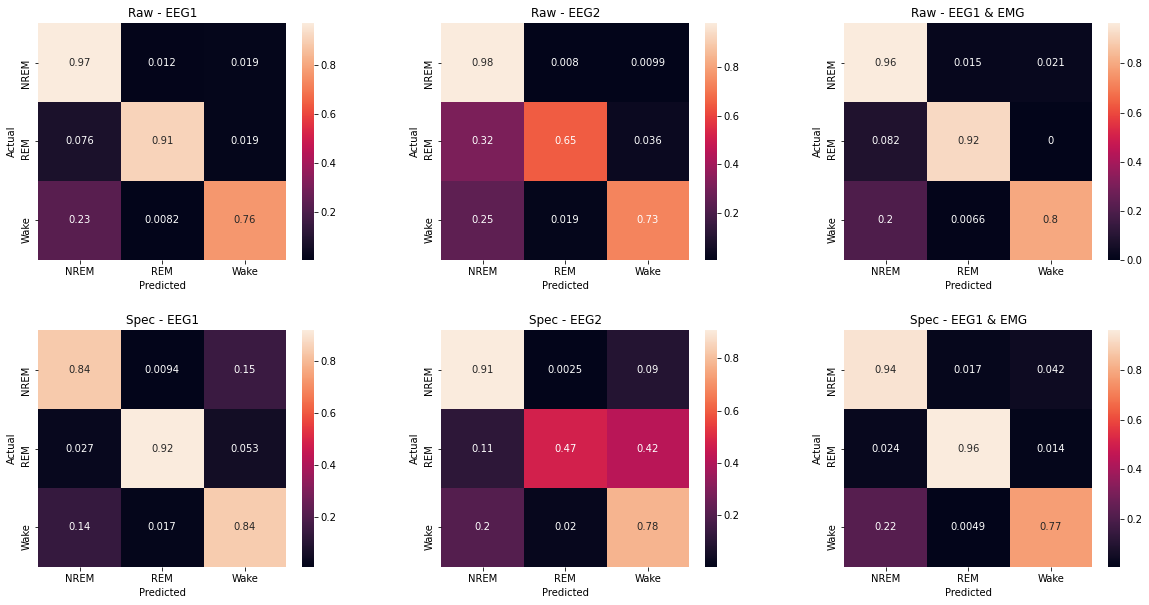

In [13]:
# List of all predictions
allPredictions = [Mnew1, Mnew2, Mnew3, Mnew4, Mnew5, Mnew6]

# Convert prediction numbers to characters representing states
state_Preds = []
for preds in allPredictions:
    resM = []
    for x in preds:
        if x==0:
            resM.append('N')
        elif x==1:
            resM.append('R')
        else:
            resM.append('W')
    state_Preds.append(resM)

# Actual labels
Mvec = rp.nts(M)

# Make and plot confusion matrices
titles = ['Raw - EEG1','Raw - EEG2','Raw - EEG1 & EMG','Spec - EEG1','Spec - EEG2','Spec - EEG1 & EMG']

plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for idx,resM in enumerate(state_Preds):
    cm = sklearn.metrics.confusion_matrix(Mvec, resM, normalize='true')
    df_cm = pd.DataFrame(cm, index=['NREM','REM','Wake'],columns=['NREM','REM','Wake'])
    plt.subplot(2,3,idx+1)
    plt.title(titles[idx])
    sns.heatmap(df_cm, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    

#### Accuracy

In [21]:
titles = ['Raw-EEG1','Raw-EEG2','Raw-EEG1&EMG','Spec-EEG1','Spec-EEG2','Spec-EEG1&EMG']

for idx,resM in enumerate(state_Preds):
    print('Accuracy for [' + titles[idx] + '] is: ' + str(np.mean(np.array(resM)==np.array(Mvec))))

Accuracy for [Raw-EEG1] is: 0.8994878916760698
Accuracy for [Raw-EEG2] is: 0.8832566617481121
Accuracy for [Raw-EEG1&EMG] is: 0.9085148858606024
Accuracy for [Spec-EEG1] is: 0.8452391285478691
Accuracy for [Spec-EEG2] is: 0.8399444492665568
Accuracy for [Spec-EEG1&EMG] is: 0.8888117350924399


Perhaps this particular recording had some features that made it difficult to classify. On a test set containing over 20 recordings, the [Spec-EEG1&EMG] model achieved an overall accuracy of 93.98%.

## Conclusion

Here we used transfer learning with ResNet18 to classify sleep states in mice. The data we used were in the form of either raw traces of EEG and EMG data or spectograms of EEG and EMG data.

We found that using the raw trace of EEG1 and EMG as the input gives us the highest test accuracy.

You can find an end-to-end pipeline to classify sleep states [here](https://github.com/parksu111/skynet).
This project will continue to be updated.